In [1]:
%load_ext dotenv
%dotenv
%matplotlib inline

In [2]:
import pandas as pd
import tempfile
import json
import os
import matplotlib.pyplot as plt

from country_list import countries_for_language
from google.cloud import storage
from matplotlib.pyplot import figure

In [3]:
BUCKET_NAME = os.environ['BUCKET_NAME']
JSON_FILE = 'all_json.pkl'

In [4]:
# get 13202 articles from cloud storage
sc = storage.Client()
temp = tempfile.TemporaryFile()
sc.download_blob_to_file(f"gs://{BUCKET_NAME}/{JSON_FILE}", temp)
df = pd.read_pickle(temp, compression=None)

FILES_COUNT = len(df)

In [5]:
class Geolocation():
    def __init__(self, df, countries, text):
        self.df = df
        self.countries = dict(countries_for_language('en'))
        self.text = text
        
    # lets one-hot-encode these countries and explore the most talked about countries.
    # first lets drop articles that don't mention countries
    # Lets first rip through the abstract and see what kind of numbers this gives us      
    def set_country_columns(self):
        for abv in self.countries.keys():
            country = self.countries[abv]
            df[country.lower()] = [text.find(" " + country.lower() + " ") for text in self.df[self.text]]
    
    # lets drop countries with no articles written about them
    def clean_columns(self):
        mentioned_countries = []
        for abreviation in self.countries.keys():
            country = self.countries[abreviation].lower()
            if country in self.df.columns:
                articles_mentioned = len(self.df[self.df[country] > -1 ][country])
                if (articles_mentioned == 0):
                    self.df = self.df.drop(country, axis=1)
                else:
                    mentioned_countries.append(country)
        self.mentioned_countries = mentioned_countries
     
    # lets plot this and see which countries have the highest reports about them
    def show_plot(self):
        figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='b')
        self.df[self.mentioned_countries].sum().add(FILES_COUNT).sort_values(ascending=False).plot.bar()
        plt.xlabel('countries')
        plt.ylabel('Frequency')
        plt.title('Frequency of Mention by Country')
        plt.show()

In [6]:
abstract = Geolocation(df, countries_for_language, 'abstract')

In [7]:
abstract.set_country_columns()

In [8]:
abstract.clean_columns()

In [9]:
len(abstract.mentioned_countries)

135

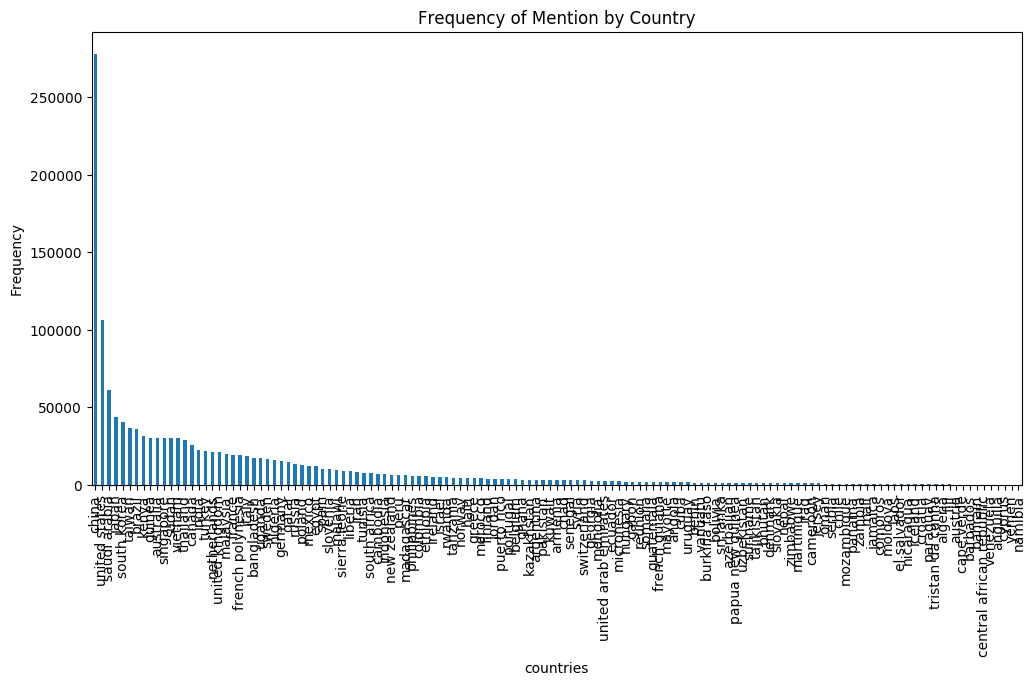

In [10]:
abstract.show_plot()

In [11]:
body_text = Geolocation(df, countries_for_language, 'body_text')

In [12]:
body_text.set_country_columns()

In [13]:
body_text.clean_columns()

In [14]:
len(body_text.mentioned_countries)

205

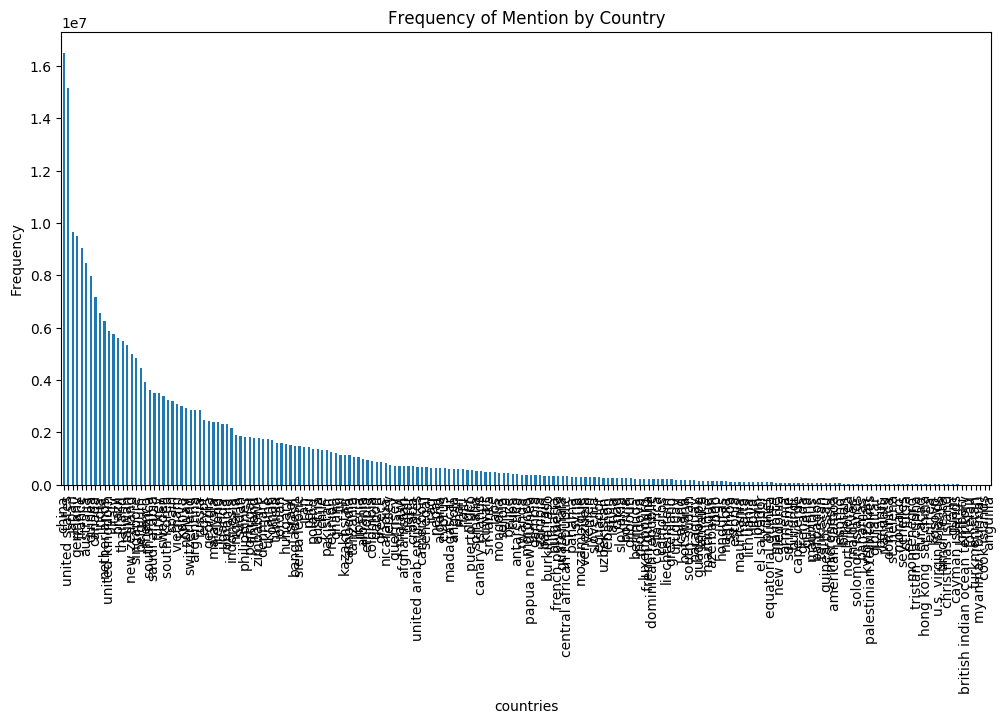

In [15]:
body_text.show_plot()

In [16]:
# Lets take a look at not just the sum but the percentage of articles in which a country is mentioned

def set_df(geo):
    percentage = []
    name = []
    count = []
    for col in geo.df[geo.mentioned_countries]:
        counter = 0
        for i in df[col]:
            if (i > -1):
                counter = counter + 1
        name.append(col)
        count.append(counter)
        percentage.append(counter/FILES_COUNT)
    return pd.DataFrame({ 'country': name, 'articles_mentioned': count, 'percentage': percentage })    

abstract_percentage_df = set_df(abstract)
body_text_percentage_df = set_df(body_text)

In [17]:
abstract_percentage_df[abstract_percentage_df['country'] == 'china']

,country,articles_mentioned,percentage
24,china,2381,0.180351


In [18]:
abstract_percentage_df.head()

,country,articles_mentioned,percentage
0,algeria,20,0.001515
1,angola,46,0.003484
2,anguilla,3,0.000227
3,argentina,78,0.005908
4,armenia,3,0.000227


In [19]:
body_text_percentage_df.head()

,country,articles_mentioned,percentage
0,afghanistan,39,0.002954
1,albania,10,0.000757
2,algeria,20,0.001515
3,american samoa,6,0.000454
4,angola,46,0.003484


In [20]:
abstract_percentage_df.sort_values(by=['percentage'], ascending=False)

,country,articles_mentioned,percentage
24,china,2381,0.180351
126,united states,1531,0.115967
58,japan,659,0.049917
19,canada,579,0.043857
5,australia,576,0.043630
...,...,...,...
129,vanuatu,3,0.000227
20,cape verde,3,0.000227
4,armenia,3,0.000227
2,anguilla,3,0.000227


In [21]:
abstract.df[abstract.mentioned_countries].sum(skipna = True).add(FILES_COUNT).sort_values(ascending=False)

china            278289
united states    106629
saudi arabia      61126
japan             44155
south korea       40405
                  ...  
venezuela           142
anguilla            135
cyprus               70
yemen                 9
namibia               3
Length: 135, dtype: int64

In [22]:
# It looks like even thoug SAUDI ARABIA and SOUTH KOREA are among the most mentioned in these article abstracts as far 
# as N values over all of the articles, the actual amount of articles the country appears in does not fall within the top five.
# CANADA and AUSTRALIA take their positions.

In [23]:
body_text_percentage_df.sort_values(by=['percentage'], ascending=False)

,country,articles_mentioned,percentage
39,china,2381,0.180351
196,united states,1531,0.115967
94,japan,659,0.049917
32,canada,579,0.043857
9,australia,576,0.043630
...,...,...,...
190,turkmenistan,1,0.000076
143,palestinian territories,1,0.000076
186,tokelau,1,0.000076
184,timor-leste,1,0.000076


In [24]:
body_text.df[body_text.mentioned_countries].sum(skipna = True).add(FILES_COUNT).sort_values(ascending=False)

china              16478112
united states      15167613
japan               9662154
germany             9496014
france              9024230
                     ...   
tokelau                5283
turkmenistan           4531
myanmar (burma)        3218
cook islands           1222
anguilla                818
Length: 205, dtype: int64

In [25]:
# It looks like even thoug GERMANY and FRANCE are among the most mentioned in these article bodies as far as N values
# over all of the articles, the actual amount of articles the country appears in does not fall within the top five.
# CANADA and AUSTRALIA take their positions. 